# MPAS Heat and Salt Budgets

***

In [1]:
import numpy as np
import xarray as xr
from datetime import datetime
from calendar import monthrange
from matplotlib import pyplot as plt
from cartopy import crs, feature
from tqdm import tqdm

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

### Map preparation

In [2]:
# Load bathymetry for plotting
filename = '/pscratch/sd/b/bmoorema/data/ETOPO_2022_v1_60s_N90W180_bed.nc'
ds = xr.open_dataset(filename).sel(lon=slice(-100, 31, 10), lat=slice(10, 81, 10))
x, y, z = [ds[name].values for name in ('lon', 'lat', 'z')]

In [3]:
def show_map(lon, lat):
    """Show mesh cell for budget calculation on map
    """

    # Make map figure
    proj, proj_ref = crs.LambertConformal(-40, 20), crs.PlateCarree()
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': proj})
    ax.set_extent([-80, -10, 20, 70])
    
    # Add land
    ax.add_feature(feature.NaturalEarthFeature(
        'physical', 'land', '50m', color='dimgray', edgecolor='k', linewidth=0.5,
    ))
    
    # Add bathymetry
    c = ax.contourf(
        x, y, -z, levels=range(0, 5001, 250), cmap='Blues', extend='max',
        transform=proj_ref, zorder=-10, alpha=0.7, antialiased=True,
    )
    
    # Show mesh cell location
    ax.plot(lon, lat, 'ro', transform=proj_ref)

    return fig, ax

***

### Calculate budget for 10-day v3 G-Case

In [4]:
# Define run and load example results file
startyear = 1948
prefix = 'timeDaily_avg_'
resultspath = '/pscratch/sd/b/bmoorema/E3SMv3/v3.LR.GMPAS-JRA1p5.pm-cpu/tests/S_1x10_ndays/run/'
runID = 'v3.LR.GMPAS-JRA1p5.pm-cpu.mpaso.hist.am'
filename = f'{resultspath}{runID}.timeSeriesStatsDaily.0001-01-01.nc'
ds = xr.open_dataset(filename)

***

### Budget variables

In [5]:
# Budget variables (missing frazil)
varNames = {
    'T': {
        'HorzAdvT'  : 'activeTracerHorizontalAdvectionTendency_temperatureHorizontalAdvectionTendency',
        'VertAdvT'  : 'activeTracerVerticalAdvectionTendency_temperatureVerticalAdvectionTendency',
        'HorzMixT'  : 'activeTracerHorMixTendency_temperatureHorMixTendency',
        'VertMixT'  : 'activeTracerVertMixTendency_temperatureVertMixTendency',
        'SurfT'     : 'activeTracerSurfaceFluxTendency_temperatureSurfaceFluxTendency',
        'NonlocalT' : 'activeTracerNonLocalTendency_temperatureNonLocalTendency',
        'FrazilT'   : 'frazilTemperatureTendency',
        'SWT'       : 'temperatureShortWaveTendency',
    },
    'S': {
        'HorzAdvS'  : 'activeTracerHorizontalAdvectionTendency_salinityHorizontalAdvectionTendency',
        'VertAdvS'  : 'activeTracerVerticalAdvectionTendency_salinityVerticalAdvectionTendency',
        'HorzMixS'  : 'activeTracerHorMixTendency_salinityHorMixTendency',
        'VertMixS'  : 'activeTracerVertMixTendency_salinityVertMixTendency',
        'SurfS'     : 'activeTracerSurfaceFluxTendency_salinitySurfaceFluxTendency',
        'NonlocalS' : 'activeTracerNonLocalTendency_salinityNonLocalTendency',
        'FrazilS'   : 'frazilSalinityTendency',
    },
}

Temperature budget variables

In [6]:
# Temperature budget
for varName, fullName in varNames['T'].items():
    attrs = ds[prefix + fullName].attrs
    long_name, units = attrs['long_name'], attrs['units']
    print(f'{varName:10s} {long_name:73s} {units}')

HorzAdvT   potential temperature tendency due to horizontal advection                C s^-1
VertAdvT   potential temperature tendency due to vertical advection                  C s^-1
HorzMixT   potential temperature tendency due to horizontal mixing (including Redi)  C s^-1
VertMixT   potential temperature tendency due to vertical mixing                     C s^-1
SurfT      potential temperature tendency due to surface fluxes                      C s^-1
NonlocalT  potential temperature tendency due to kpp non-local flux                  C s^-1
FrazilT    temperature tendency due to frazil processes                              m C s^-1
SWT        potential temperature tendency due to penetrating shortwave               C s^-1


Salinity budget variables

In [7]:
# Salinity budget
for varName, fullName in varNames['S'].items():
    attrs = ds[prefix + fullName].attrs
    long_name, units = attrs['long_name'], attrs['units']
    print(f'{varName:10s} {long_name:60s} {units}')

HorzAdvS   salinity tendency due to horizontal advection                1.e-3 s^-1
VertAdvS   salinity tendency due to vertical advection                  1.e-3 s^-1
HorzMixS   salinity tendency due to horizontal mixing (including Redi)  1.e-3 s^-1
VertMixS   salinity tendency due to vertical mixing                     1.e-3 s^-1
SurfS      salinity tendency due to surface fluxes                      1.e-3 s^-1
NonlocalS  salinity tendency due to kpp non-local flux                  1.e-3 s^-1
FrazilS    salinity tendency due to frazil processes                    m 1.e-3 s^-1


***

### Example location

Choose a point in the interior Atlantic

In [8]:
# Mesh cell to evaluate
nCell = 210022

# Get coordinates
filename = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/IcoswISC30E3r5/mpaso.IcoswISC30E3r5.20231120.nc'
ds = xr.open_dataset(filename)
lon, lat = [np.rad2deg(ds[f'{name}Cell'][nCell].values) for name in ('lon', 'lat')]
lon = lon - 360
depth = ds.refBottomDepth.values
H_0 = ds.layerThickness[0, nCell, :].values

Show location on map

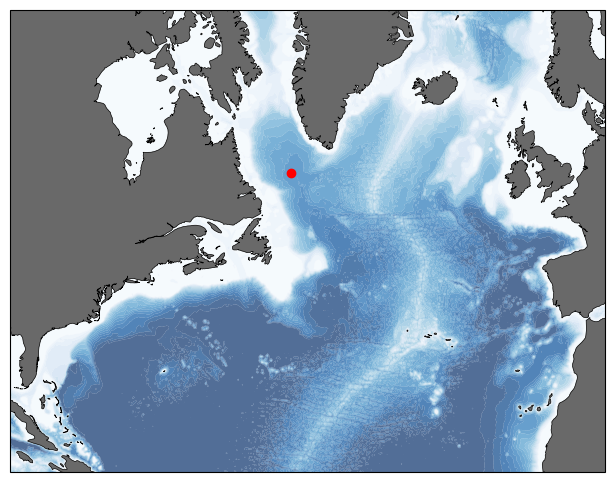

In [9]:
# Make map figure
fig, ax = show_map(lon, lat)

***

### Budget calculation

**LHS** from high frequency output

In [10]:
# Define variable names
names = ['temperature', 'salinity', 'layerThickness']

# Load restart file and extract variables at nCell
filename = f'{resultspath}{runID}.highFrequencyOutput.0001-01-01_00.00.00.nc'
ds = xr.open_dataset(filename)
T, S, H = [ds[name][:, nCell, :].values for name in names]

# Update thickness-weighted profiles
LHS = {
    'T': np.diff(T * H, axis=0),
    'S': np.diff(S * H, axis=0),
}

**RHS** from daily budget tendency variables

In [11]:
# Initialize RHS and total_seconds to zero
RHS = {}
total_seconds = 86400

# Load results file and extract layerThickness
filename = f'{resultspath}{runID}.timeSeriesStatsDaily.0001-01-01.nc'
ds = xr.open_dataset(filename)
H = ds[prefix + 'layerThickness'][1:, nCell, :].values

# Sum RHS terms for T and S, weight by layerThickness and seconds, add to running RHS
for var in ['T', 'S']:
    terms = []
    for name in varNames[var].values():
        array = ds[prefix + name][1:, nCell, :].values
        if 'frazil' not in name:
            array = array * H
        terms.append(array)
    RHS[var] = sum(terms) * total_seconds

Calculate residual

In [12]:
# Calculate residual (frazil + monthly averaging of layerThickness)
RES = {var: (LHS[var] - RHS[var]) / (H_0[None, :] * total_seconds) for var in ['T', 'S']}

***

### Visualization

Remaining issues in the residual profiles
   * Upper layer noise outside of the frazil formation regions
   * Still some unexplained systematic residual in the interior

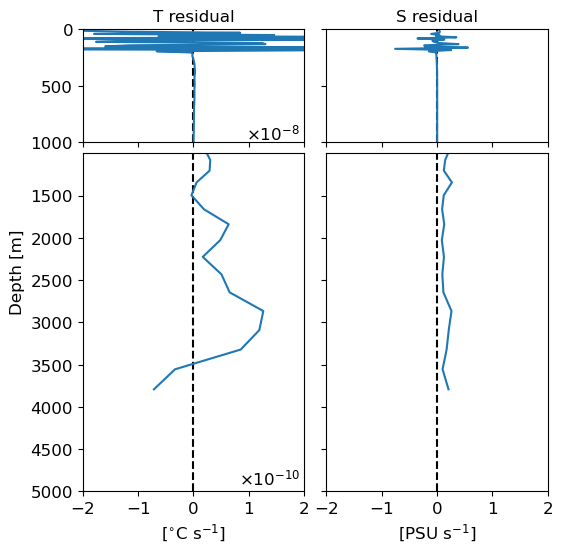

In [13]:
# Plot residual
gridspec_kw = {'height_ratios': [1, 3], 'hspace': 0.05, 'wspace': 0.1}
fig, axs = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw=gridspec_kw)
xlabels = ['[$^{\\circ}$C s$^{-1}$]', '[PSU s$^{-1}$]']
for col, var, xlabel in zip(axs.T, ['T', 'S'], xlabels):
    col[0].set_title(f'{var} residual')
    col[0].xaxis.set_ticklabels('')
    col[1].set_xlabel(xlabel)
    for ax, power, ylim in zip(col, [8, 10], [(1000, 0), (5000, 1001)]):
        ax.plot([0, 0], ylim, 'k--')
        ax.plot(RES[var].mean(axis=0) * 2*10**power, depth)
        ax.set_xlim(-2, 2)
        ax.set_ylim(ylim)
        if var == 'T':
            ax.text(0.98, 0.02, f'$\\times 10^{{-{power}}}$', ha='right', transform=ax.transAxes)
        else:
            ax.yaxis.set_ticklabels('')
axs[1, 0].set_ylabel('Depth [m]', y=0.65)
plt.show()

***

### Budget calculation for older CORE-II G-Cases

In [14]:
# Define run and load example results file
nCell = 78357
startyear = 1948
restartyears = [11, 21]
prefix = 'timeMonthly_avg_'
resultspath = '/pscratch/sd/b/bmoorema/run_001_062/'
runID = '20210421_sim7_CORE_60to30E2r2.mpaso'

# Get coordinates
filename = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
ds = xr.open_dataset(filename)
lon, lat = [np.rad2deg(ds[f'{name}Cell'][nCell].values) for name in ('lon', 'lat')]
lon = lon - 360
depth = ds.refBottomDepth.values
H_0 = ds.layerThickness[0, nCell, :].values

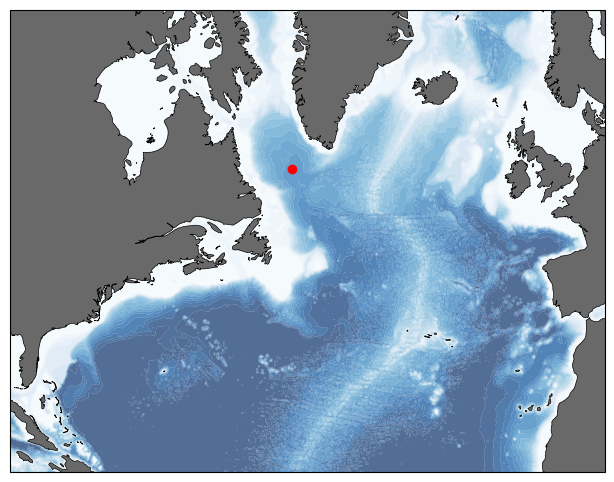

In [16]:
# Make map figure
fig, ax = show_map(lon, lat)

**LHS** from restarts

In [17]:
# Initialize LHS as lists and define variable names
LHS = {'T': [], 'S': []}
names = 'temperature', 'salinity', 'layerThickness'

# Loop through adjacent restarts
for year in restartyears:

    # Load restart file and extract variables at nCell
    filename = f'{resultspath}{runID}.rst.{year:04d}-01-01_00000.nc'
    ds = xr.open_dataset(filename)
    T, S, H = [ds[name][0, nCell, :].values for name in names]

    # Update thickness-weighted profiles
    LHS['T'].append(T * H)
    LHS['S'].append(S * H)

# Get difference between restarts
LHS['T'] = LHS['T'][1] - LHS['T'][0]
LHS['S'] = LHS['S'][1] - LHS['S'][0]

**RHS** from monthly budget tendency variables

In [18]:
# Initialize RHS and total_seconds to zero
RHS = {'T': 0, 'S': 0}
total_seconds = 0

# Loop through monthly files between restarts
for year in tqdm(range(*restartyears)):
    for month in range(1, 13):

        # Get seconds in month
        _, days = monthrange(year + startyear - 1, month)
        seconds = days * 86400

        # Load results file and extract layerThickness
        filename = f'{resultspath}{runID}.hist.am.timeSeriesStatsMonthly.{year:04d}-{month:02d}-01.nc'
        ds = xr.open_dataset(filename)
        H = ds[prefix + 'layerThickness'][0, nCell, :].values

        # Sum RHS terms for T and S, weight by layerThickness and seconds, add to running RHS
        for var in ['T', 'S']:
            terms = []
            for name in varNames[var].values():
                if prefix + name in ds:
                    terms.append(ds[prefix + name][0, nCell, :].values)
            RHS[var] = RHS[var] + sum(terms) * H * seconds

        # Update total_seconds
        total_seconds += seconds

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Calculate residual

In [19]:
# Calculate residual (frazil + monthly averaging of layerThickness)
RES = {var: (LHS[var] - RHS[var]) / (H_0 * total_seconds) for var in ['T', 'S']}

/tmp/ipykernel_98531/3762647313.py:2: RuntimeWarning: invalid value encountered in divide
  RES = {var: (LHS[var] - RHS[var]) / (H_0 * total_seconds) for var in ['T', 'S']}


Plot

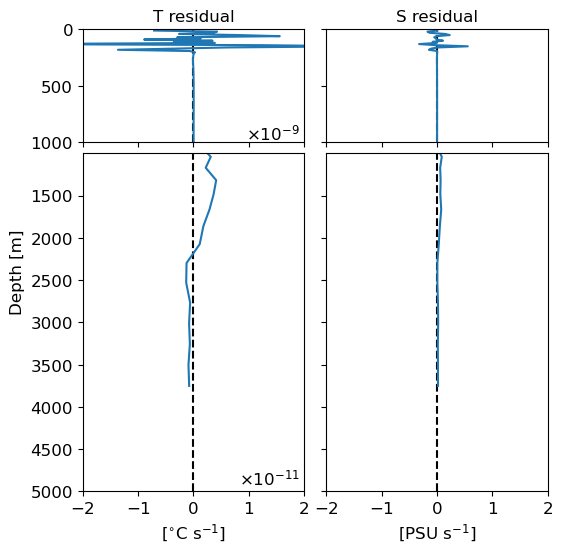

In [20]:
# Plot residual
gridspec_kw = {'height_ratios': [1, 3], 'hspace': 0.05, 'wspace': 0.1}
fig, axs = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw=gridspec_kw)
xlabels = ['[$^{\\circ}$C s$^{-1}$]', '[PSU s$^{-1}$]']
for col, var, xlabel in zip(axs.T, ['T', 'S'], xlabels):
    col[0].set_title(f'{var} residual')
    col[0].xaxis.set_ticklabels('')
    col[1].set_xlabel(xlabel)
    for ax, power, ylim in zip(col, [9, 11], [(1000, 0), (5000, 1001)]):
        ax.plot([0, 0], ylim, 'k--')
        ax.plot(RES[var] * 2*10**power, depth)
        ax.set_xlim(-2, 2)
        ax.set_ylim(ylim)
        if var == 'T':
            ax.text(0.98, 0.02, f'$\\times 10^{{-{power}}}$', ha='right', transform=ax.transAxes)
        else:
            ax.yaxis.set_ticklabels('')
axs[1, 0].set_ylabel('Depth [m]', y=0.65)
plt.show()